# Evaluating Models

These codeblocks will load the .keras files containing the saved models and then evaluate them

In [ ]:
from google.colab import drive
import numpy as np
import keras
from tqdm import tqdm
import tensorflow as tf

drive.mount("/content/gdrive/")

#Required to load the models as this was used in training, not utilised in this notebook, a separate function for euclid distance exists
@keras.saving.register_keras_serializable(package="my_package", name="landmark_distance")
def landmark_distance(y_true,y_pred):

  distance = tf.sqrt(tf.reduce_sum(tf.square(y_true-y_pred),-1))

  return tf.reduce_mean(distance)

#Able to change the colour of the visualised points
def visualise_pts_1(img, pts,color):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], color)
  plt.show()

#Load the three models (files should be included in the submission zip)
model_1 = keras.models.load_model('/content/gdrive/MyDrive/Colab-Notebooks/AML-coursework/Best_CNN_model.keras')
model_2 = keras.models.load_model('/content/gdrive/MyDrive/Colab-Notebooks/AML-coursework/CNN_Model_2_Reduced_layers.keras')
model_3 = keras.models.load_model('/content/gdrive/MyDrive/Colab-Notebooks/AML-coursework/CNN_Model_3_Reduced_filters.keras')

#Load training Data
transform_data = np.load('/content/gdrive/MyDrive/Colab-Notebooks/AML-coursework/PROCESSED_DATA_FINAL.npz',allow_pickle=True)
x = transform_data['x_train']
y = transform_data['y_train']

#Split training data
train_test_split = int(np.round(x.shape[0]*0.9))
x_test = x[train_test_split:]
y_test = y[train_test_split:]


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Calculating average prediction time and histogram of prediction time

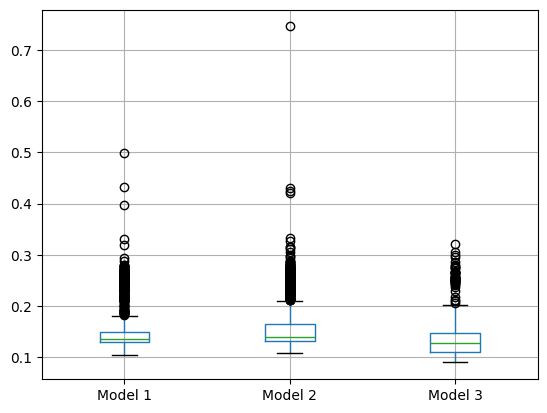

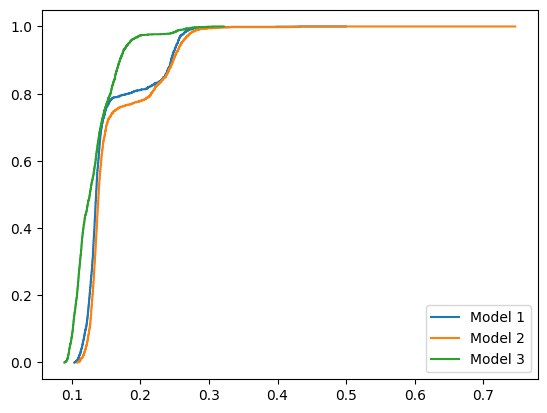

In [ ]:
from matplotlib import pyplot as plt
import time
import pandas as pd
#Calculate the time taken for each image and then plot on a histogram
#Different models have different colours
def prediction_time(model,x_test):
  y = []
  #Find time between prediction in seconds
  for image in tqdm(x_test):
    image = image.reshape (1,180,180)
    start_time = time.time()
    predictions = model.predict(image,verbose=0)
    end_time = time.time()

    elapsed_time = np.round(end_time - start_time,5)
    y.append(elapsed_time)


  print("\n\nMEAN: ",np.mean(y))
  print("\n\n99TH PERCENTILE:",np.percentile(y,99),"\n\n")
  return y

data_1 = prediction_time(model_1,x_test)
data_2 = prediction_time(model_2,x_test)
data_3 = prediction_time(model_3,x_test)
dataframe = pd.DataFrame()
dataframe.insert(0,"Model 1",data_1)
dataframe.insert(1,"Model 2",data_2)
dataframe.insert(2,"Model 3",data_3)
dataframe.boxplot()
plt.show()
plt.step(np.sort(data_1),np.linspace(0,1,len(data_1)))
plt.step(np.sort(data_2),np.linspace(0,1,len(data_2)))
plt.step(np.sort(data_3),np.linspace(0,1,len(data_3)))
plt.legend(["Model 1","Model 2","Model 3"])
plt.show()

## Calculation average landmark distance

100%|██████████| 1687/1687 [04:27<00:00,  6.31it/s]




MEAN:  24.631245688910656


99.5TH PERCENTILE: 69.99335522045878 




100%|██████████| 1687/1687 [04:33<00:00,  6.18it/s]




MEAN:  28.97635210984735


99.5TH PERCENTILE: 102.45050476020712 




100%|██████████| 1687/1687 [03:55<00:00,  7.16it/s]




MEAN:  28.217641302932314


99.5TH PERCENTILE: 82.5576490121504 




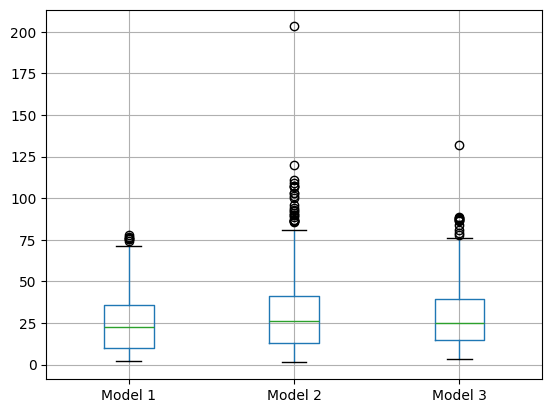

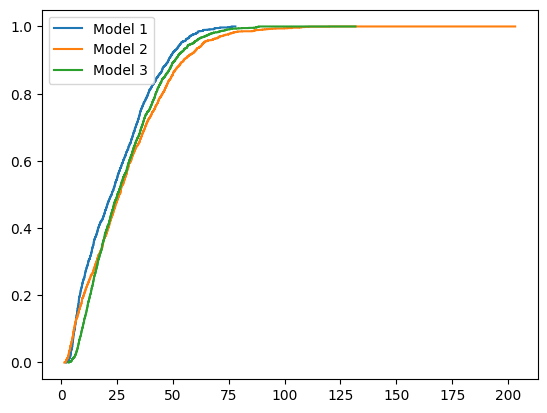

In [ ]:
#Calculate mean Euclidean distance of all point on an image
def euclid_dist(pred_pts, gt_pts):
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.mean(np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1)))

#Find mean Euclidean distance for all images and plot on a histogram
#Different colours are for different models
def prediction_dist(model,x_test,y_test,colour="red"):
  y = []
  predictions = []

  for i in tqdm(range(len(x_test))):
    img = x_test[i].reshape(1,180,180)
    prediction = model.predict(img,verbose=0)
    predictions.append(prediction)
    y.append(euclid_dist(prediction,y_test[i]))
  print("\n\nMEAN: ",np.mean(y))
  bad_threshold = np.percentile(y,99.5)
  print("\n\n99.5TH PERCENTILE:",bad_threshold,"\n\n")

  #Create an index of images that are above the 99.5th percentile
  bad_index = []
  for i in range(len(y)):
    if y[i] > bad_threshold:
      bad_index.append(i)
  return predictions,bad_index,y


model_1_predictions, model_1_failure_idx, data_4 = prediction_dist(model_1,x_test,y_test)
model_2_predictions, model_2_failure_idx, data_5 = prediction_dist(model_2,x_test,y_test,"blue")
model_3_predictions, model_3_failure_idx, data_6 = prediction_dist(model_3,x_test,y_test,"green")

dataframe = pd.DataFrame()
dataframe.insert(0,"Model 1",data_4)
dataframe.insert(1,"Model 2",data_5)
dataframe.insert(2,"Model 3",data_6)
dataframe.boxplot()

plt.show()
plt.step(np.sort(data_4),np.linspace(0,1,len(data_4)))
plt.step(np.sort(data_5),np.linspace(0,1,len(data_5)))
plt.step(np.sort(data_6),np.linspace(0,1,len(data_6)))
plt.legend(["Model 1","Model 2","Model 3"])
plt.show()

## Display poor performing images

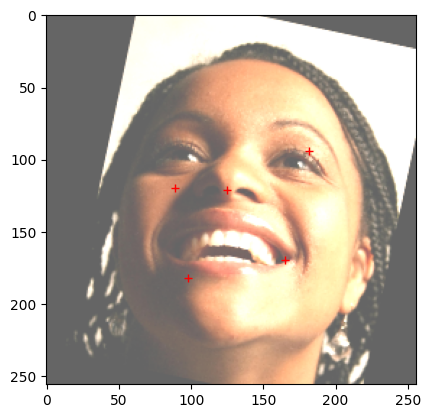

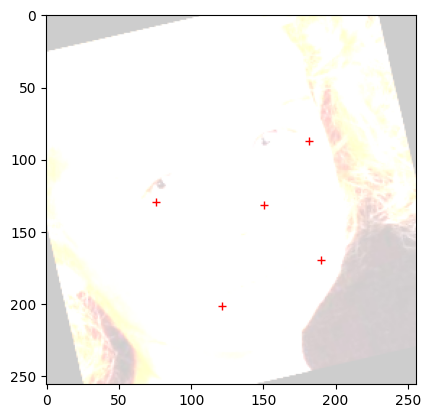

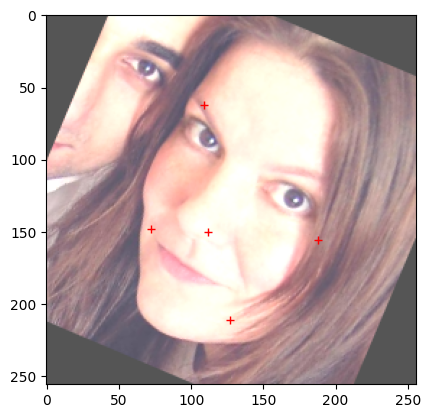

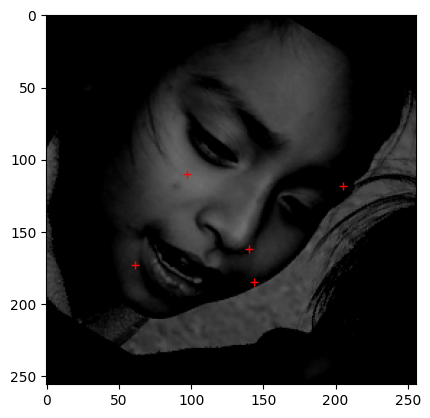

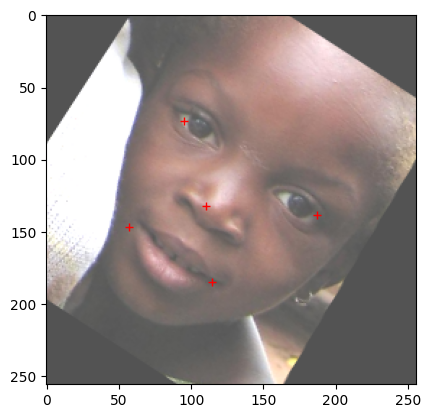

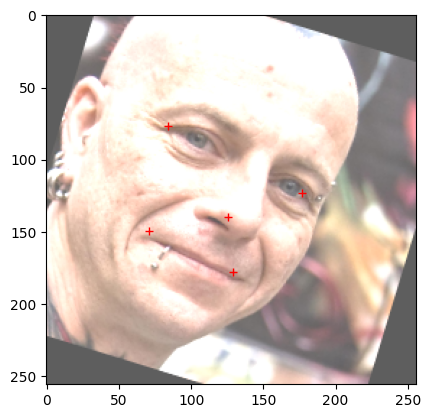

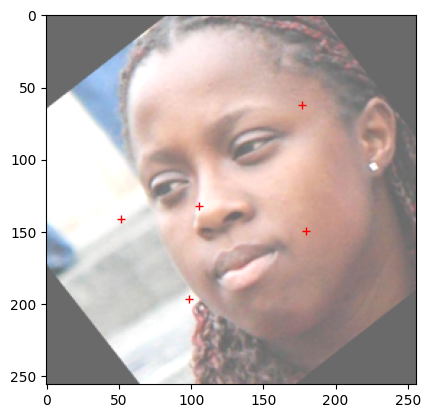

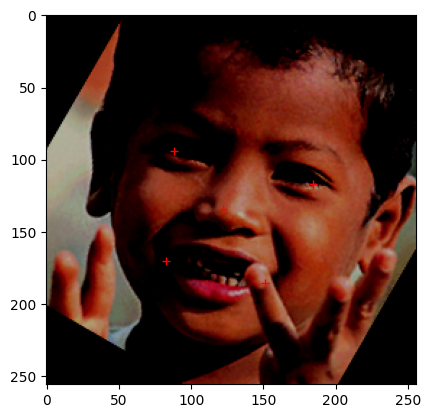

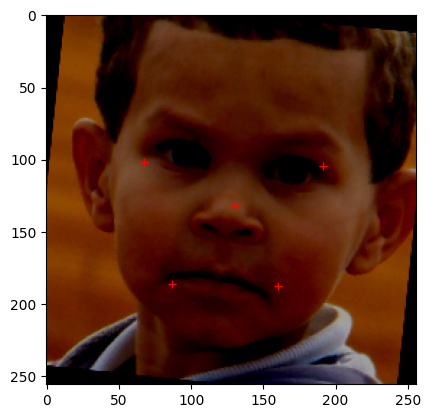

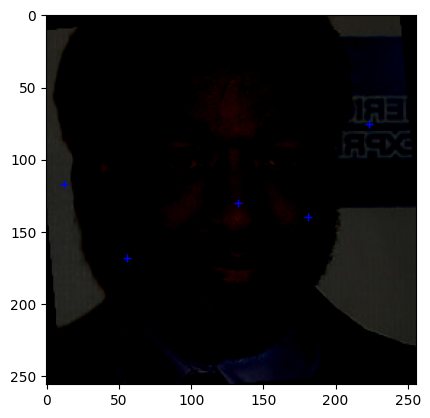

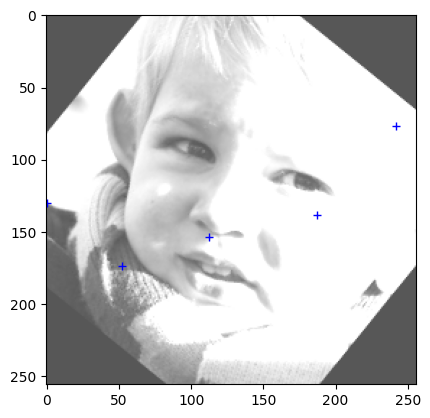

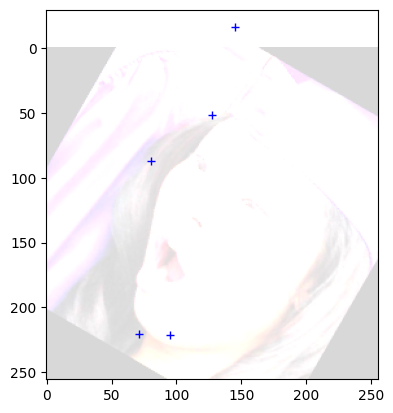

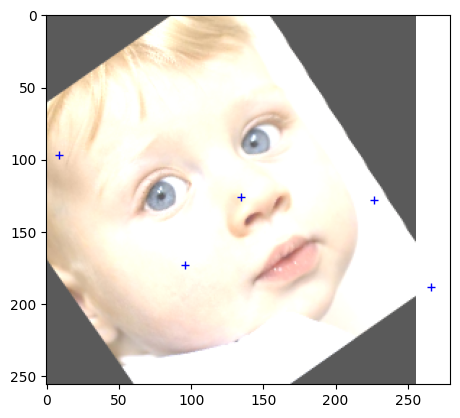

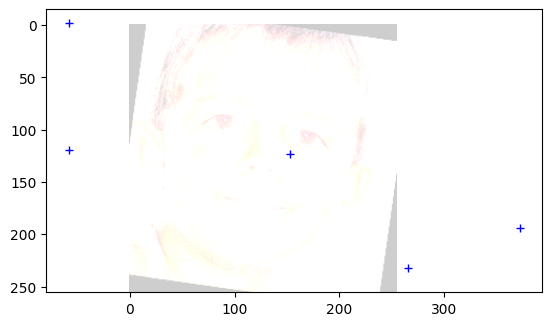

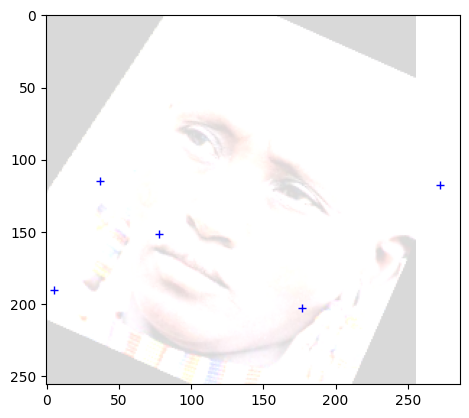

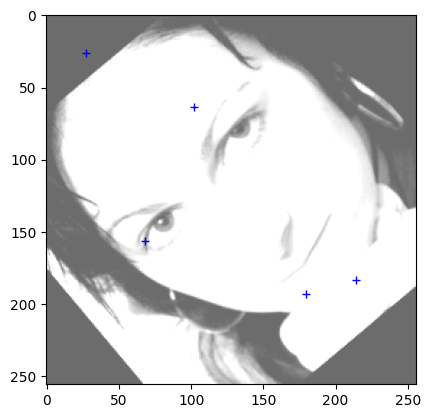

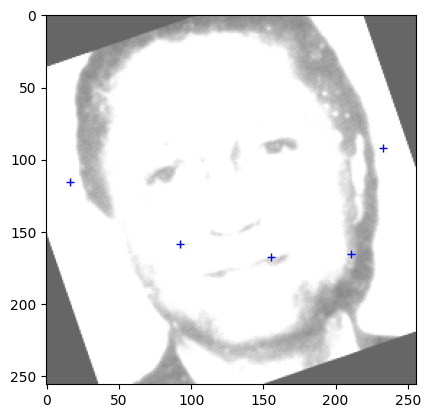

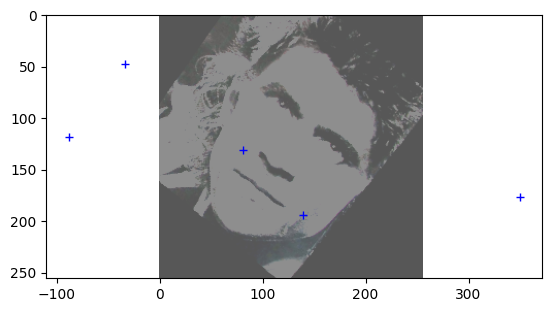

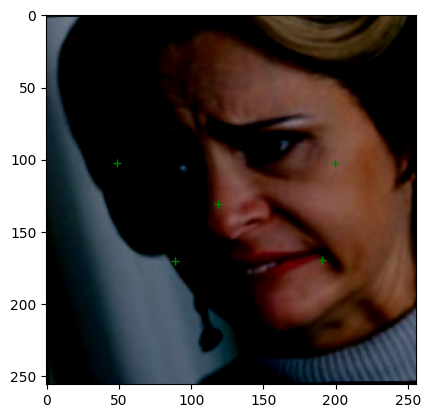

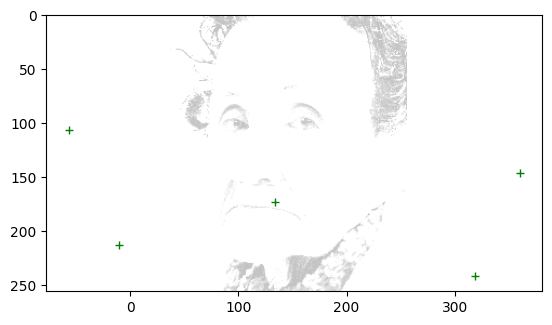

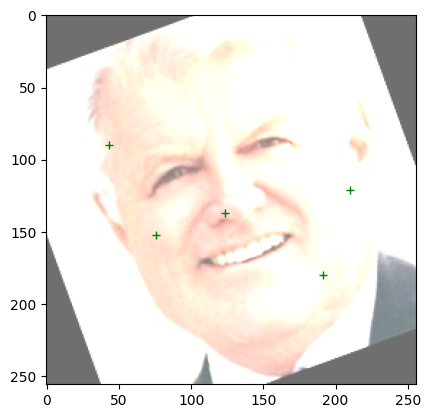

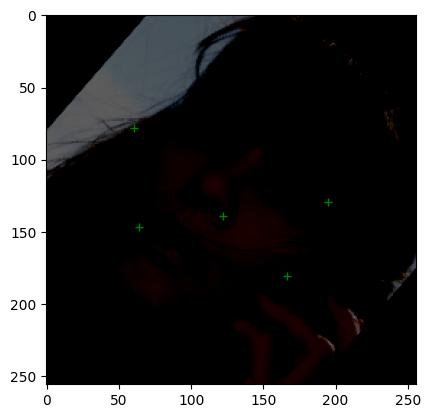

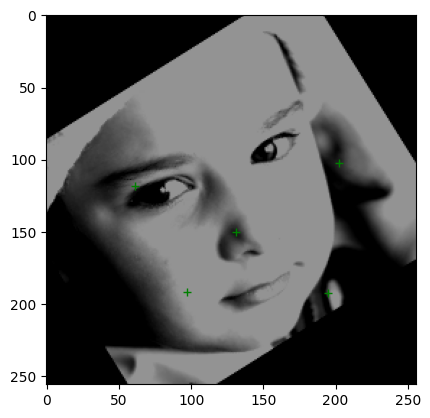

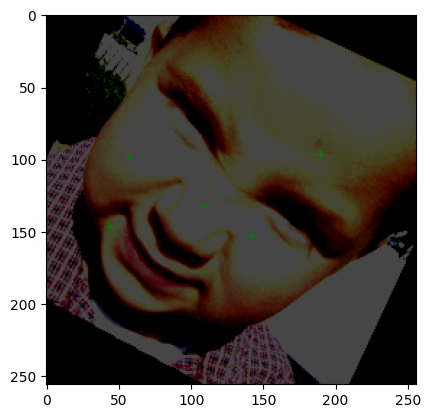

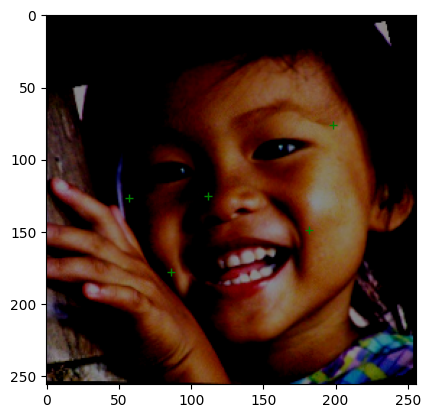

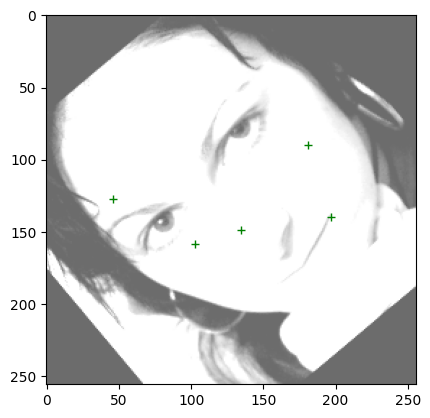

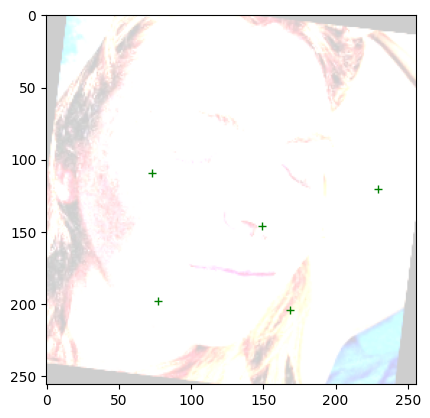

In [ ]:
transform_data = np.load('/content/gdrive/MyDrive/Colab-Notebooks/AML-coursework/VISUALISE_VAL_SET.npz',allow_pickle=True)
colour_img = transform_data['x_train']
#Poor performing is decided by an index created in the previous code block
# It is the 0.05% worst performing images of each model
#Different models have different colour crosses
def visualise_poor_performing(model_pred,model_idx,colour='+r'):
  pt_bias = (256 - 180)/2
  for i in model_idx:
    pred = model_pred[i][0]
    visualise_pts_1(colour_img[i],(pred+pt_bias),colour)
visualise_poor_performing(model_1_predictions,model_1_failure_idx)
visualise_poor_performing(model_2_predictions,model_2_failure_idx,'+b')
visualise_poor_performing(model_3_predictions,model_3_failure_idx,'+g')

## Creating Prediction on test data

Get the test images

In [ ]:
!wget "https://sussex.box.com/shared/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a" -O face_alignment_test_images.npz
test_data = np.load('face_alignment_test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

--2025-05-14 16:49:33--  https://sussex.box.com/shared/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a [following]
--2025-05-14 16:49:33--  https://sussex.box.com/public/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a [following]
--2025-05-14 16:49:33--  https://sussex.app.box.com/public/static/8n5ofhb9so0ia85g4bbcmnt3h6z53m9a
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

Pre-processing the test data

In [ ]:
import cv2

def cropImg(img):
  h = 180
  w = 180
  centre = 128
  x = centre - w/2
  y = centre - h/2
  return img[int(y):int(y+h), int(x):int(x+w)]

def preProcess(img):

  #Turn image grey
  grey_img = np.uint8(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY))

  #Equalise histogram to improve contrast and help extract features
  histogram_equalised = cv2.equalizeHist(grey_img)

  #Apply laplacian of gaussian
  laplacian_img = cv2.Laplacian(histogram_equalised,cv2.CV_64F)

  #Crop image
  cropped_img = cropImg(laplacian_img)
  return (cropped_img/255)

def preprocessSet(imgset):
  output_set = np.zeros((imgset.shape[0],180,180))
  for i in tqdm(range(imgset.shape[0])):
    output_set[i] = preProcess(imgset[i])
  return output_set

processed_test = preprocessSet(test_images)
print(processed_test.shape)

100%|██████████| 554/554 [00:00<00:00, 1118.94it/s]

(554, 180, 180)


100%|██████████| 554/554 [01:29<00:00,  6.20it/s]


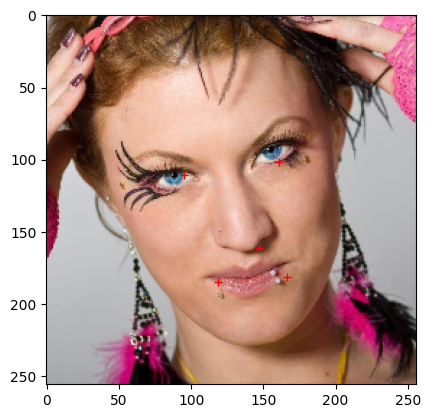

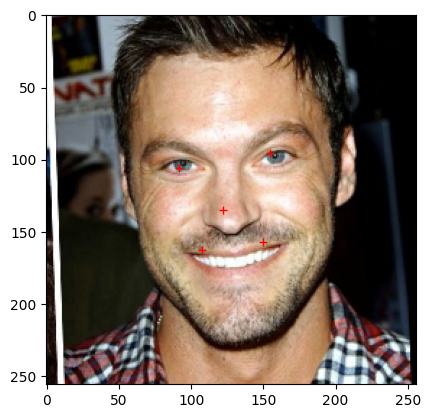

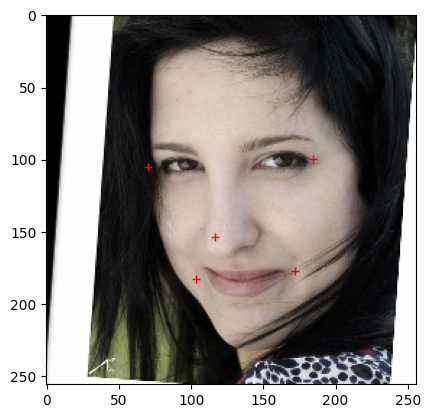

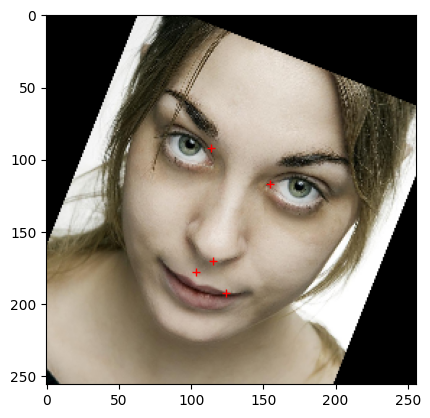

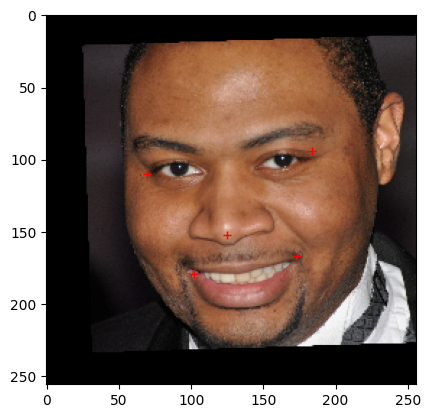

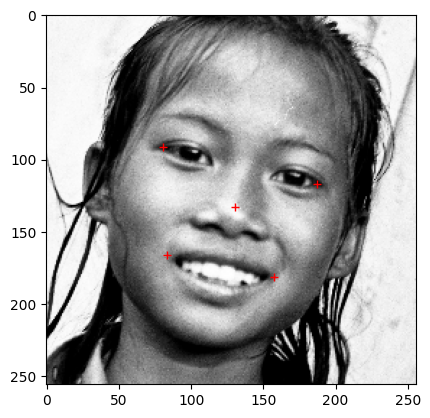

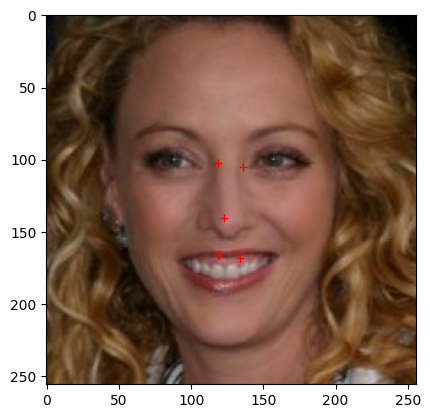

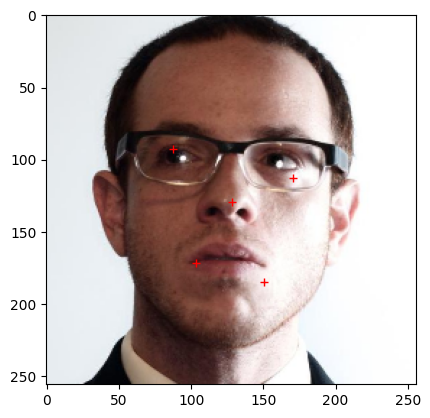

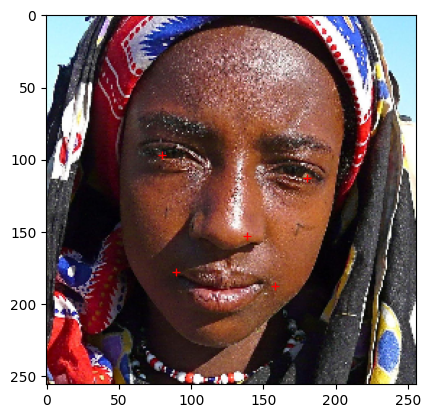

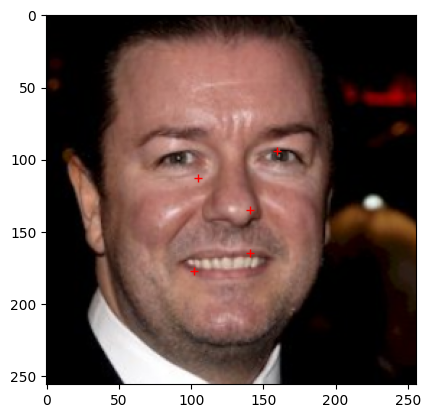

In [ ]:
from matplotlib import pyplot as plt
pt_bias = (256 - 180)/2

#Predict the test set
def predict_test(model,images):
  predictions = np.zeros((images.shape[0],5,2))
  for i in tqdm(range(len(images))):
    img = images[i].reshape(1,180,180)
    predictions[i] = model.predict(img,verbose=0)[0] + pt_bias
  return predictions

test_predictions = predict_test(model_1,processed_test)

#Show some examples
for i in range(10):
  idx = np.random.randint(0,test_images.shape[0])
  visualise_pts_1(test_images[idx],test_predictions[idx],"+r")

In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==5*2, 'wrong number of points provided. There should be 5 points with 2 values (x,y) per point'
    np.savetxt(location + '/results_task2.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

save_as_csv(test_predictions)